In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from tqdm import tqdm_notebook

from fbprophet import Prophet
import datetime as dt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Preprocessing

In [2]:
#import data
all_data=pd.read_csv('./Data_Output/all_data.csv')

In [3]:
#convert dates from string to datetime objects
all_data['game_date']=pd.to_datetime(all_data['game_date']).dt.date
all_data['game_date']=pd.to_datetime(all_data['game_date'])
all_data['purchase_date']=pd.to_datetime(all_data['purchase_date']).dt.date
all_data['purchase_date']=pd.to_datetime(all_data['purchase_date'])

In [4]:
#slice dataframe to needed columns
ticket_data=all_data[['acct_id',
                      'game_date',
                      'purchase_date',
                      '30_day_buyer',
                      'ticket_scanned',
                      'section_100',
                      'section_500',
                      'section_200', 
                      'ticket_type']]

In [5]:
#convert categorical features to 0 and 1
ticket_data=pd.get_dummies(ticket_data, columns=['ticket_type'])
ticket_data.head()

,acct_id,game_date,purchase_date,30_day_buyer,ticket_scanned,section_100,section_500,section_200,ticket_type_Game Pack,ticket_type_Group,ticket_type_Season Ticket,ticket_type_Single Games
0,4309949.0,2017-04-11,2016-11-07,0,0.0,0,1,0,1,0,0,0
1,7292203.0,2017-04-11,2017-02-23,0,0.0,1,0,0,0,0,0,1
2,7292203.0,2017-04-11,2017-02-23,0,1.0,1,0,0,0,0,0,1
3,7292203.0,2017-04-11,2017-02-23,0,0.0,1,0,0,0,0,0,1
4,7292203.0,2017-04-11,2017-02-23,0,1.0,1,0,0,0,0,0,1


In [6]:
#group by game_date
agg_dict={'acct_id':np.size,
          '30_day_buyer': np.sum,
          'ticket_scanned': np.sum,
          'section_100': np.sum,
          'section_200': np.sum,
          'section_500': np.sum,
          'ticket_type_Game Pack': np.sum,
          'ticket_type_Group': np.sum,
          'ticket_type_Season Ticket': np.sum,
          'ticket_type_Single Games': np.sum}

column_names={'acct_id': 'tickets_sold',
              '30_day_buyer': 'total_ticket_purchased_30d_prior',
              'ticket_scanned': 'total_tickets_scanned',
              'section_100': 'total_sec100',
              'section_500': 'total_sec500',
              'section_200': 'total_sec200',
              'ticket_type_Game Pack': 'total_GamePack',
              'ticket_type_Group': 'total_Group',
              'ticket_type_Season Ticket': 'total_SeasonTicket',
              'ticket_type_Single Games': 'total_SingleTicket'
                }
num_tickets=ticket_data.groupby('game_date').agg(agg_dict).rename(columns=column_names)
num_tickets.reset_index(drop=False, inplace=True)

In [7]:
num_tickets.head()

,game_date,tickets_sold,total_ticket_purchased_30d_prior,total_tickets_scanned,total_sec100,total_sec200,total_sec500,total_GamePack,total_Group,total_SeasonTicket,total_SingleTicket
0,2017-04-11,39383.0,2608,29896.0,18378,7053,13952,9940.0,254.0,20047.0,9142.0
1,2017-04-12,27600.0,4327,19069.0,13426,5739,8435,1780.0,1251.0,19300.0,5269.0
2,2017-04-13,30168.0,6382,22378.0,14285,5723,10160,1085.0,3293.0,19481.0,6309.0
3,2017-04-14,36372.0,10216,28773.0,17389,6720,12263,3166.0,1341.0,19954.0,11911.0
4,2017-04-15,36682.0,5844,27052.0,17039,6834,12809,4395.0,3230.0,19769.0,9288.0


In [8]:
num_tickets.shape

(242, 11)

In [9]:
#make every feature a percent of total tickets purchased by game
num_tickets_per=num_tickets
columns_to_adjust=num_tickets_per.columns
columns_to_adjust = [e for e in columns_to_adjust if e not in ('game_date','tickets_sold')]
columns_to_adjust

for column in columns_to_adjust:
    num_tickets_per[column]=(num_tickets_per[column]/num_tickets_per['tickets_sold'])

In [10]:
num_tickets_per.head()

,game_date,tickets_sold,total_ticket_purchased_30d_prior,total_tickets_scanned,total_sec100,total_sec200,total_sec500,total_GamePack,total_Group,total_SeasonTicket,total_SingleTicket
0,2017-04-11,39383.0,0.066221,0.759109,0.466648,0.179087,0.354265,0.252393,0.006449,0.509027,0.232131
1,2017-04-12,27600.0,0.156775,0.690906,0.486449,0.207935,0.305616,0.064493,0.045326,0.699275,0.190906
2,2017-04-13,30168.0,0.211549,0.741779,0.473515,0.189704,0.336781,0.035965,0.109155,0.645750,0.209129
3,2017-04-14,36372.0,0.280875,0.791076,0.478088,0.184758,0.337155,0.087045,0.036869,0.548609,0.327477
4,2017-04-15,36682.0,0.159315,0.737473,0.464506,0.186304,0.349190,0.119814,0.088054,0.538929,0.253203


In [11]:
#create a dataframe that ends at 08/31/2019 to fit model
num_tickets_per_nosept2019=num_tickets_per[num_tickets_per['game_date'].dt.date<dt.date(2019, 9, 1)]
num_tickets_per_nosept2019.reset_index(drop=True, inplace=True)
num_tickets_per_nosept2019.tail()

,game_date,tickets_sold,total_ticket_purchased_30d_prior,total_tickets_scanned,total_sec100,total_sec200,total_sec500,total_GamePack,total_Group,total_SeasonTicket,total_SingleTicket
224,2019-08-18,21799.0,0.470801,0.892656,0.404927,0.252902,0.342172,0.023258,0.060874,0.352126,0.563741
225,2019-08-27,22659.0,0.512203,0.882651,0.508010,0.187343,0.304647,0.027848,0.070347,0.354826,0.546979
226,2019-08-28,21561.0,0.463012,0.885024,0.479570,0.251704,0.268726,0.025370,0.134363,0.368118,0.472149
227,2019-08-30,23803.0,0.570684,0.905306,0.397849,0.215687,0.386464,0.030626,0.023148,0.328950,0.617275
228,2019-08-31,24748.0,0.515880,0.905487,0.452885,0.239696,0.307419,0.038144,0.029255,0.322329,0.610272


# (A) FORECASTING TICKET SALES

In [18]:
# define a funciton to get time-series forecast of column in dataframe using fbprophet
# the model is fitted with data from beginning of season 2017 up to 08/31/2019
# forecast 30 days to 09/30/2019, and get forecast speciifcally for the last 3 games on Sept 27, 28, 29
# column in prediction_summary titled 'y_<column_name>' are actuals
# in the case of date ranges 09/01/2019 to 09/30/2019, column 'y_<column_name>' 
# are actuals known about the column up to 08/31/2019 
# (for example, for date 09/15/2019 the y_tickets_sold value 
# represents the tickets already purchased up to 08/31/2019 for game day 09/15/2019)

def get_predictions(column):
    forecast={}
    df=num_tickets_per_nosept2019[['game_date', column]].rename(columns={'game_date': 'ds', column: 'y'})
    df_2=num_tickets_per[['game_date', column]].rename(columns={'game_date': 'ds', column: 'y'})
    
    model= Prophet(weekly_seasonality=True)
    model.fit(df)
    fit = model.make_future_dataframe(periods=30)
    df_model=model.predict(fit)
    df_sub=df_model[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    prediction_summary=df_2.merge(df_sub, on='ds', how='left')
    prediction_summary.rename(columns={'y': 'y_'+column}, inplace=True)
    
    forecast['model']=model
    forecast['df_model']=df_model
    forecast['prediction_summary']=prediction_summary
    return forecast

In [20]:
#create a dictionary of all the time series fits
#do not need daily seasonality as this is for time of day.
results = {}
for c in tqdm_notebook(num_tickets_per_nosept2019.columns[1:]):
    result = get_predictions(c)
    results[c]= result

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

## 1. Forecasting Number of Purchased Tickets

### Method I: forecasting the total tickets sold by game date

In [21]:
# parse to time-series dictionary to results
df_method1=results['tickets_sold']['prediction_summary'][['ds',
                                                           'yhat',
                                                           'yhat_lower',
                                                           'yhat_upper']].rename(columns={'ds': 'dates',
                                                                                                  'yhat': 'forecasted_tickets_sold',
                                                                                                  'yhat_lower': 'forecast_lower',
                                                                                                 'yhat_upper': 'forecast_upper'})

model_tix_sold=results['tickets_sold']['model']
df_model_tix_sold=results['tickets_sold']['df_model']

In [22]:
#forecast results for ticket sales (method 1) for last 3 games (Sept 27, 28, 29)
df_method1.tail(3)

,dates,forecasted_tickets_sold,forecast_lower,forecast_upper
239,2019-09-27,16366.740105,12006.611211,21321.500425
240,2019-09-28,20723.491821,15890.816453,25995.594981
241,2019-09-29,18950.375256,13891.342332,23621.990215


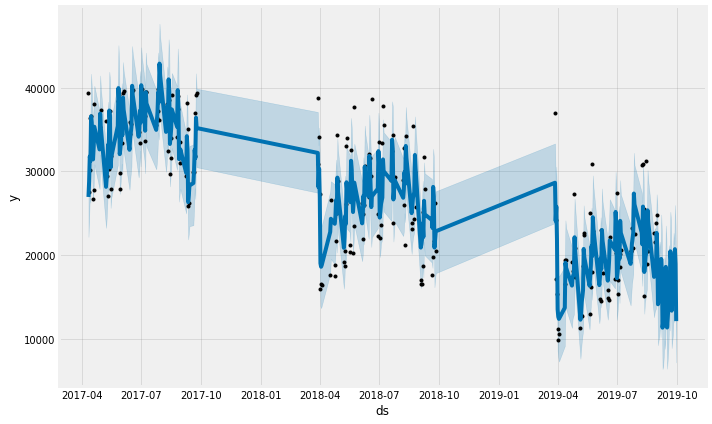

In [23]:
plot1 = model_tix_sold.plot(df_model_tix_sold)
#blue line is predicited values
#black dots are actuals

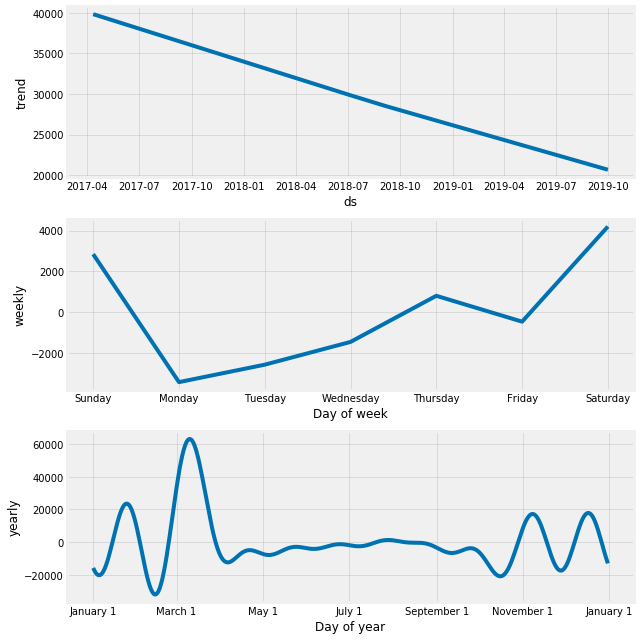

In [24]:
plot2=model_tix_sold.plot_components(df_model_tix_sold)

In [25]:
#perform cross-validation to determine how good model was
df_cv = cross_validation(model_tix_sold, initial='150 days', period='45 days', horizon = '90 days')
df_cv.tail()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-12-30 00:00:00 and 2019-06-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
251,2019-08-18,23390.539834,18377.798578,27812.611409,21799.0,2019-06-02
252,2019-08-27,15942.308593,10986.086852,20639.302618,22659.0,2019-06-02
253,2019-08-28,16751.275400,12054.562788,21453.083332,21561.0,2019-06-02
254,2019-08-30,16994.630184,12194.193444,21851.452485,23803.0,2019-06-02
255,2019-08-31,21304.590235,16969.798993,25798.773428,24748.0,2019-06-02


In [26]:
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,coverage
22,89 days,2.990714e+07,5468.742367,4559.887935,0.206176,0.44
98,90 days,2.977996e+07,5457.102007,4502.210962,0.203491,0.44
1,90 days,2.752363e+07,5246.296399,4358.543277,0.191270,0.44
139,90 days,2.953697e+07,5434.792167,4492.288478,0.195980,0.44
255,90 days,2.952720e+07,5433.893883,4490.878041,0.193130,0.44


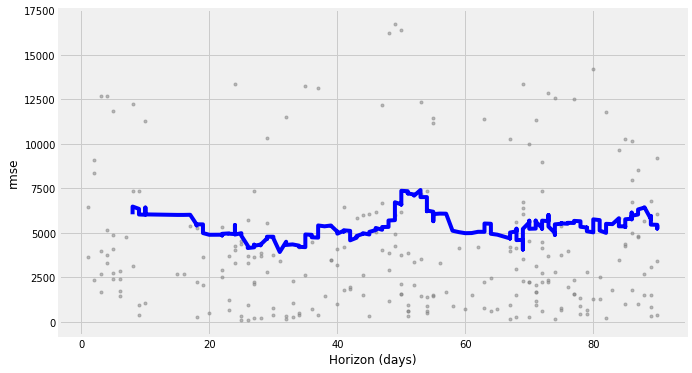

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')
#blue line is root mean square error over rolling window of dots (error varies between 3000 tickets and 7500 tickes)

## Method II: Forecasting the ratio of tickets purchased 30 days prior to game to total tickets purchased. Applying ratio (scaled) to actuals (total tickets already purchased for games in Sept 2019) to get forecasted total tickets purchased for Sept 2019 

In [28]:
#parse through time-series dictionary for results
df_method2_30d=results['total_ticket_purchased_30d_prior']['prediction_summary'][['ds',
                                                           'yhat',
                                                           'yhat_lower',
                                                           'yhat_upper']].rename(columns={'ds': 'dates',
                                                                                                  'yhat': 'forecasted__ticket_purchased_30d_prior',
                                                                                                  'yhat_lower': 'forecast_lower',
                                                                                                 'yhat_upper': 'forecast_upper'})

model_30d=results['total_ticket_purchased_30d_prior']['model']
df_model_30d=results['total_ticket_purchased_30d_prior']['df_model']

In [29]:
#results of forecast for what percent of tickets for a given game will be purchased 30 days prior to game
df_method2_30d.tail(3)

,dates,forecasted__ticket_purchased_30d_prior,forecast_lower,forecast_upper
239,2019-09-27,0.354060,0.280915,0.428937
240,2019-09-28,0.314911,0.239407,0.385892
241,2019-09-29,0.292045,0.215352,0.363678


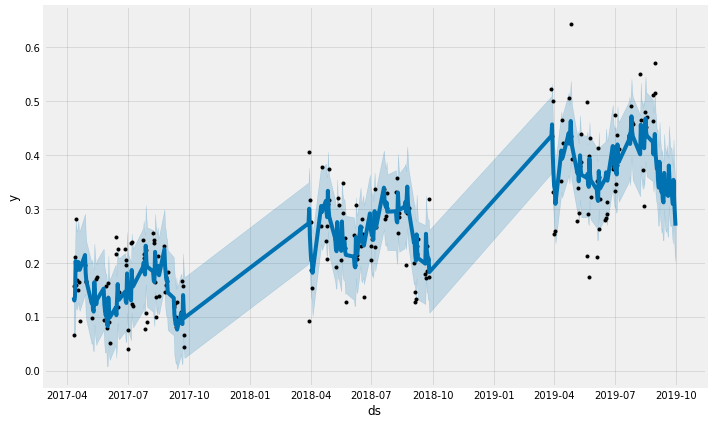

In [30]:
plot1 = model_30d.plot(df_model_30d)
#blue line is predicited values
#black dots are actuals

#Plot shows that between 2017, 2018, 2019 season there has been an 
#increase in the percent of tickets sold being purchased 30 days prior to game

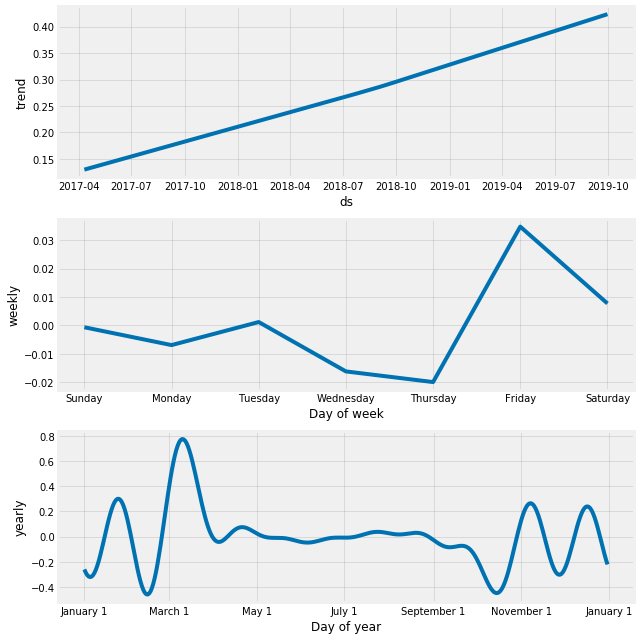

In [31]:
plot2=model_30d.plot_components(df_model_30d)
#Friday is exceptionally popular for the 30-day ticket buyer

In [32]:
df_cv_30d = cross_validation(model_30d, initial='150 days', period='45 days', horizon = '90 days')
df_cv_30d.tail()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-12-30 00:00:00 and 2019-06-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
251,2019-08-18,0.410943,0.346162,0.484125,0.470801,2019-06-02
252,2019-08-27,0.379865,0.305610,0.453179,0.512203,2019-06-02
253,2019-08-28,0.362450,0.288980,0.432300,0.463012,2019-06-02
254,2019-08-30,0.385036,0.310461,0.464574,0.570684,2019-06-02
255,2019-08-31,0.347758,0.273414,0.417135,0.515880,2019-06-02


In [33]:
df_p_30d = performance_metrics(df_cv_30d)
df_p_30d.tail()

,horizon,mse,rmse,mae,mape,coverage
22,89 days,0.008128,0.090158,0.067073,0.213764,0.52
98,90 days,0.008129,0.090164,0.067217,0.214295,0.52
1,90 days,0.010694,0.103412,0.074943,0.228806,0.52
139,90 days,0.010772,0.103787,0.076464,0.237592,0.52
255,90 days,0.011802,0.108637,0.081185,0.244931,0.48


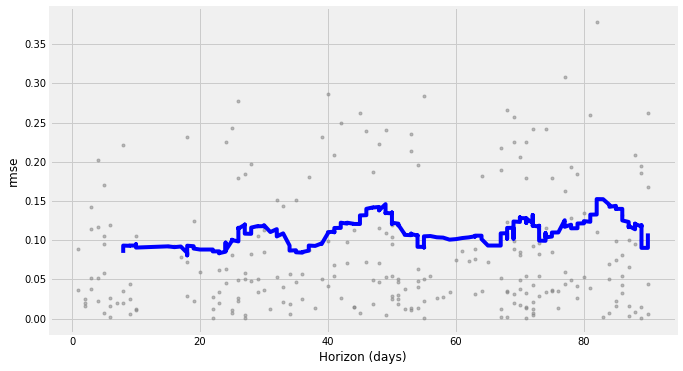

In [34]:
fig = plot_cross_validation_metric(df_cv_30d, metric='rmse')
#rmse varies between 7-16% (of percent of total tickets that are sold within 30 days prior to a game)

In [35]:
#create dataframe forecasted percent of tickets purchased 30 days prior with tickets that have already been purchased
# by 08/31/19 for a given game 
df_1=results['tickets_sold']['prediction_summary'][['ds', 'y_tickets_sold']].rename(columns={'y_tickets_sold': 'actuals',
                                                                                             'ds': 'game_date'})

df_2=results['total_ticket_purchased_30d_prior']['prediction_summary'].rename(columns={'ds':'game_date',
                                                                                               'y_total_ticket_purchased_30d_prior': 'ratio_tix_30d_prior',
                                                                                               'yhat': 'forecasted_ratio_tix_30d',
                                                                                               'yhat_lower': 'forecast_lower',
                                                                                               'yhat_upper': 'forecast_upper'})
df_method2=df_1.merge(df_2, on='game_date', how='left')
df_method2.tail(3)

,game_date,actuals,ratio_tix_30d_prior,forecasted_ratio_tix_30d,forecast_lower,forecast_upper
239,2019-09-27,15016.0,0.023308,0.354060,0.280915,0.428937
240,2019-09-28,10794.0,0.015749,0.314911,0.239407,0.385892
241,2019-09-29,12580.0,0.007472,0.292045,0.215352,0.363678


In [36]:
#calculate forecasted number of tickets
df_method2['forecast_total_tix']=(1+(df_method2['forecasted_ratio_tix_30d']-df_method2['ratio_tix_30d_prior']))*df_method2['actuals']
df_method2['forecast_tix_upper']=(1+(df_method2['forecast_upper']-df_method2['ratio_tix_30d_prior']))*df_method2['actuals']
df_method2['forecast_tix_lower']=(1+(df_method2['forecast_lower']-df_method2['ratio_tix_30d_prior']))*df_method2['actuals']

In [37]:
df_method2.tail(3)

,game_date,actuals,ratio_tix_30d_prior,forecasted_ratio_tix_30d,forecast_lower,forecast_upper,forecast_total_tix,forecast_tix_upper,forecast_tix_lower
239,2019-09-27,15016.0,0.023308,0.354060,0.280915,0.428937,19982.569542,21106.925400,18884.218797
240,2019-09-28,10794.0,0.015749,0.314911,0.239407,0.385892,14023.149957,14789.319309,13208.157102
241,2019-09-29,12580.0,0.007472,0.292045,0.215352,0.363678,16159.926332,17061.063210,15195.123665


## Forecasting Other Features:
* scanned tickets
* section_100
* section_200
* section_500
* Game Pack tickets
* Group tickets
* Season tickets
* Single tickets

In [38]:
#adding results of both methods onto simplified dataframe
df_forecast=df_method2.merge(df_method1, left_on='game_date', right_on='dates', how='left')

column_names={'forecast_total_tix': 'forecast_total_tix_method2',
              'forecast_tix_upper': 'method2_upper',
              'forecast_tix_lower': 'method2_lower',
              'forecasted_tickets_sold': 'forecast_total_tix_method1',
              'forecast_lower_y': 'method1_lower',
              'forecast_upper_y': 'method1_upper'}

df_forecast=df_forecast[['game_date',
                         'forecasted_tickets_sold',
                         'forecast_lower_y',
                         'forecast_upper_y',
                         'forecast_total_tix',
                         'forecast_tix_lower',
                         'forecast_tix_upper']].tail(3).rename(columns=column_names)
df_forecast

,game_date,forecast_total_tix_method1,method1_lower,method1_upper,forecast_total_tix_method2,method2_lower,method2_upper
239,2019-09-27,16366.740105,12006.611211,21321.500425,19982.569542,18884.218797,21106.925400
240,2019-09-28,20723.491821,15890.816453,25995.594981,14023.149957,13208.157102,14789.319309
241,2019-09-29,18950.375256,13891.342332,23621.990215,16159.926332,15195.123665,17061.063210


In [39]:
#including forecast of features
features=num_tickets_per.columns[3:]
print(features)

for f in features:
    feature_df=results[f]['prediction_summary'].tail(3)[['ds', 'yhat']].rename(columns={'ds': 'game_date', 'yhat': 'yhat_'+f})
    df_forecast=df_forecast.merge(feature_df, on='game_date', how='left')

Index(['total_tickets_scanned', 'total_sec100', 'total_sec200', 'total_sec500',
       'total_GamePack', 'total_Group', 'total_SeasonTicket',
       'total_SingleTicket'],
      dtype='object')


In [41]:
df_forecast

,game_date,forecast_total_tix_method1,method1_lower,method1_upper,forecast_total_tix_method2,method2_lower,method2_upper,yhat_total_tickets_scanned,yhat_total_sec100,yhat_total_sec200,yhat_total_sec500,yhat_total_GamePack,yhat_total_Group,yhat_total_SeasonTicket,yhat_total_SingleTicket
0,2019-09-27,16366.740105,12006.611211,21321.500425,19982.569542,18884.218797,21106.925400,0.808534,0.489014,0.219416,0.294298,0.073280,0.108873,0.544932,0.312733
1,2019-09-28,20723.491821,15890.816453,25995.594981,14023.149957,13208.157102,14789.319309,0.860113,0.489320,0.209525,0.304923,0.098099,0.113154,0.493798,0.345820
2,2019-09-29,18950.375256,13891.342332,23621.990215,16159.926332,15195.123665,17061.063210,0.857149,0.505758,0.219866,0.279262,0.111043,0.107064,0.546302,0.299083


# (B) FORECASTING TURNSTILE ACTIVITY BY TICKET TYPE

In [42]:
#forecasted percent of ticket scans
results['total_tickets_scanned']['prediction_summary'].tail(3)

,ds,y_total_tickets_scanned,yhat,yhat_lower,yhat_upper
239,2019-09-27,0.0,0.808534,0.750556,0.865833
240,2019-09-28,0.0,0.860113,0.803281,0.918337
241,2019-09-29,0.0,0.857149,0.799573,0.909494


In [43]:
#average rmse for forecasted % of ticket_scans
model_test=results['total_tickets_scanned']['model']
df_cv_test = cross_validation(model_test, initial='150 days', period='45 days', horizon = '90 days')
df_p_test = performance_metrics(df_cv_test)
df_p_test['rmse'].mean()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-12-30 00:00:00 and 2019-06-02 00:00:00


0.13538305362807007

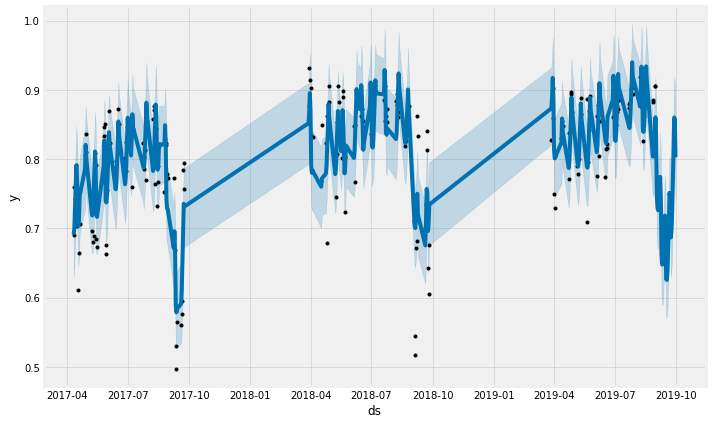

In [44]:
#ticket scan forecast
plot1 = results['total_tickets_scanned']['model'].plot(results['total_tickets_scanned']['df_model'])

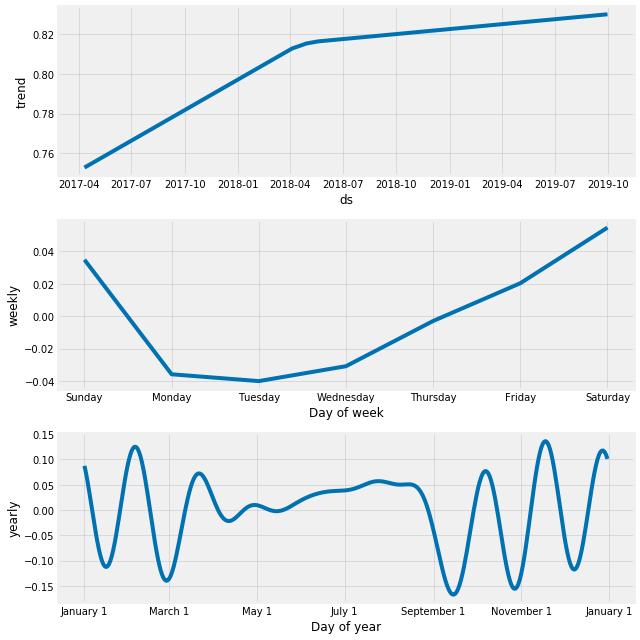

In [45]:
plot2=results['total_tickets_scanned']['model'].plot_components(results['total_tickets_scanned']['df_model'])

In [46]:
#create feature for whether a given ticket was a ticket_type and scanned
ticket_scans=ticket_data
ticket_scans['SeasonTicket_scanned']=np.where(((ticket_scans['ticket_type_Season Ticket']==1) & (ticket_scans['ticket_scanned']==1)), 1, 0)
ticket_scans['GamePack_scanned']=np.where(((ticket_scans['ticket_type_Game Pack']==1) & (ticket_scans['ticket_scanned']==1)), 1, 0)
ticket_scans['Group_scanned']=np.where(((ticket_scans['ticket_type_Group']==1) & (ticket_scans['ticket_scanned']==1)), 1, 0)
ticket_scans['SingleGame_Scanned']=np.where(((ticket_scans['ticket_type_Single Games']==1) & (ticket_scans['ticket_scanned']==1)), 1, 0)


In [47]:
ticket_scans.columns

Index(['acct_id', 'game_date', 'purchase_date', '30_day_buyer',
       'ticket_scanned', 'section_100', 'section_500', 'section_200',
       'ticket_type_Game Pack', 'ticket_type_Group',
       'ticket_type_Season Ticket', 'ticket_type_Single Games',
       'SeasonTicket_scanned', 'GamePack_scanned', 'Group_scanned',
       'SingleGame_Scanned'],
      dtype='object')

In [48]:
ticket_scans=ticket_scans[['acct_id', 'game_date','ticket_scanned', 'SeasonTicket_scanned', 'GamePack_scanned', 'Group_scanned',
       'SingleGame_Scanned']]

In [49]:
#calculate total ticket_types that were scanned by game
agg_dict={'acct_id': np.size,
          'ticket_scanned': np.sum,
          'SeasonTicket_scanned': np.sum,
          'GamePack_scanned': np.sum,
          'Group_scanned': np.sum,
          'SingleGame_Scanned': np.sum}

column_names={'acct_id': 'total_tix_sold',
              'ticket_scanned': 'total_tix_scanned',
              'SeasonTicket_scanned': 'total_SeasonTickets_scanned',
              'GamePack_scanned': 'total_GamePack_scanned',
              'Group_scanned': 'total_Group_scanned',
              'SingleGame_Scanned': 'total_SingleGame_scanned'}

ticket_scans=ticket_scans.groupby('game_date').agg(agg_dict).rename(columns=column_names)
ticket_scans.reset_index(drop=False, inplace=True)

In [50]:
ticket_scans.head()

,game_date,total_tix_sold,total_tix_scanned,total_SeasonTickets_scanned,total_GamePack_scanned,total_Group_scanned,total_SingleGame_scanned
0,2017-04-11,39383.0,29896.0,15111,6100,228,8457
1,2017-04-12,27600.0,19069.0,11837,1024,1178,5030
2,2017-04-13,30168.0,22378.0,12731,635,2976,6036
3,2017-04-14,36372.0,28773.0,14341,1732,1203,11497
4,2017-04-15,36682.0,27052.0,13063,2357,2915,8717


In [51]:
#make every feature a percent of ticket_purchased
ticket_scans_per=ticket_scans
columns_to_adjust=ticket_scans_per.columns
columns_to_adjust = [e for e in columns_to_adjust if e not in ('game_date', 'total_tix_sold','total_tix_scanned')]
columns_to_adjust

for column in columns_to_adjust:
    ticket_scans_per[column]=(ticket_scans_per[column]/ticket_scans_per['total_tix_scanned'])

In [52]:
ticket_scans_per_nosept2019=ticket_scans_per[ticket_scans_per['game_date'].dt.date<dt.date(2019, 9, 1)]
ticket_scans_per_nosept2019.tail()

,game_date,total_tix_sold,total_tix_scanned,total_SeasonTickets_scanned,total_GamePack_scanned,total_Group_scanned,total_SingleGame_scanned
224,2019-08-18,21799.0,19459.0,0.307673,0.014184,0.060640,0.617503
225,2019-08-27,22659.0,20000.0,0.306700,0.015700,0.072550,0.605050
226,2019-08-28,21561.0,19082.0,0.323603,0.014674,0.138455,0.523268
227,2019-08-30,23803.0,21549.0,0.289619,0.017588,0.024549,0.668244
228,2019-08-31,24748.0,22409.0,0.288813,0.023785,0.029765,0.657638


In [53]:
#forecast percent of ticket_type being scanned at game
def get_predictions_tixScanned(column):
    forecast={}
    df=ticket_scans_per_nosept2019[['game_date', column]].rename(columns={'game_date': 'ds', column: 'y'})
    df_2=ticket_scans_per[['game_date']].rename(columns={'game_date': 'ds'})
    
    model= Prophet(weekly_seasonality=True)
    model.fit(df)
    fit = model.make_future_dataframe(periods=30)
    df_model=model.predict(fit)
    df_sub=df_model[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    prediction_summary=df_2.merge(df_sub, on='ds', how='left')
    prediction_summary.rename(columns={'y': 'y_'+column}, inplace=True)
    
    forecast['model']=model
    forecast['df_model']=df_model
    forecast['prediction_summary']=prediction_summary
    return forecast

In [54]:
#load results of forecast into dictionary
results_tix_scanned = {}
for c in tqdm_notebook(ticket_scans_per_nosept2019.columns[3:]):
    result = get_predictions_tixScanned(c)
    results_tix_scanned[c]= result

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
#combine forecasts for all ticket_types scan percents into single dataframe
df_forecast_tixscanned=df_forecast
df_forecast_tixscanned=df_forecast_tixscanned[['game_date', 'forecast_total_tix_method1', 'method1_lower',
       'method1_upper', 'forecast_total_tix_method2', 'method2_lower',
       'method2_upper', 'yhat_total_tickets_scanned']]

In [56]:
df_forecast_tixscanned

,game_date,forecast_total_tix_method1,method1_lower,method1_upper,forecast_total_tix_method2,method2_lower,method2_upper,yhat_total_tickets_scanned
0,2019-09-27,16366.740105,12006.611211,21321.500425,19982.569542,18884.218797,21106.925400,0.808534
1,2019-09-28,20723.491821,15890.816453,25995.594981,14023.149957,13208.157102,14789.319309,0.860113
2,2019-09-29,18950.375256,13891.342332,23621.990215,16159.926332,15195.123665,17061.063210,0.857149


In [57]:
features=ticket_scans_per_nosept2019.columns[3:]

for f in features:
    feature_df=results_tix_scanned[f]['prediction_summary'].tail(3)[['ds', 'yhat']].rename(columns={'ds': 'game_date', 'yhat': 'yhat_'+f})
    df_forecast_tixscanned=df_forecast_tixscanned.merge(feature_df, on='game_date', how='left')

In [58]:
df_forecast_tixscanned

,game_date,forecast_total_tix_method1,method1_lower,method1_upper,forecast_total_tix_method2,method2_lower,method2_upper,yhat_total_tickets_scanned,yhat_total_SeasonTickets_scanned,yhat_total_GamePack_scanned,yhat_total_Group_scanned,yhat_total_SingleGame_scanned
0,2019-09-27,16366.740105,12006.611211,21321.500425,19982.569542,18884.218797,21106.925400,0.808534,0.537735,0.044077,0.115877,0.341411
1,2019-09-28,20723.491821,15890.816453,25995.594981,14023.149957,13208.157102,14789.319309,0.860113,0.505622,0.064234,0.120266,0.360856
2,2019-09-29,18950.375256,13891.342332,23621.990215,16159.926332,15195.123665,17061.063210,0.857149,0.569976,0.068135,0.113331,0.312987
